In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import seaborn as sns
from imblearn.over_sampling import SMOTE 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
data = pd.read_csv('datasets/Dataset-SA.csv')

In [16]:
len(data)

205052

In [17]:
data['text'] = data['Review'].fillna('') + ' ' + data['Summary'].fillna('')
data['text'] = data['text'].str.strip()
data = data[data['text'] != '']
data = data.dropna(subset=['Rate', 'Sentiment'])

In [18]:

data['score'] = data['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})

In [19]:
data.head()

,product_name,product_price,Rate,Review,Summary,Sentiment,text,score
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive,super! great cooler excellent air flow and for...,1
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive,awesome best budget 2 fit cooler nice cooling,1
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive,fair the quality is good but the power of air ...,1
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative,useless product very bad product its a only a fan,-1
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral,fair ok ok product,0


In [20]:
# sentiment distribution
data['score'].value_counts()
data['score'].value_counts() / len(data) * 100

score
 1    81.238722
-1    13.768349
 0     4.992929
Name: count, dtype: float64

In [21]:
data['text_length'] = data['text'].str.len()
data['text_length'].max(), data['text_length'].min(), data['text_length'].mean()

(616, 2, np.float64(54.207881004633016))

In [22]:
X = data['text']
y = data['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
len(X_train), len(X_test)

(164040, 41010)

In [24]:
vectorizer_bow = CountVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

In [25]:
smote = SMOTE(random_state=42)
X_train_tfidf_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

pd.Series(y_train_balanced).value_counts()

score
 1    133264
-1    133264
 0    133264
Name: count, dtype: int64

In [26]:
# Naive Bayes (BoW)
nb_model = MultinomialNB()
nb_model.fit(X_train_bow, y_train)
y_pred_nb = nb_model.predict(X_test_bow)
print("\nNaive Bayes (BoW) Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb, zero_division=0))
print("Macro F1-score:", f1_score(y_test, y_pred_nb, average='macro'))


Naive Bayes (BoW) Accuracy: 0.9101194830529139
Classification Report:
               precision    recall  f1-score   support

          -1       0.84      0.82      0.83      5646
           0       0.41      0.50      0.45      2048
           1       0.96      0.95      0.96     33316

    accuracy                           0.91     41010
   macro avg       0.74      0.76      0.74     41010
weighted avg       0.92      0.91      0.91     41010

Macro F1-score: 0.7445098174309592


In [27]:
# Logistic Regression (BoW)
lr_model_bow = LogisticRegression(max_iter=1000, penalty='l2', C=1.0, multi_class='ovr', class_weight='balanced')
lr_model_bow.fit(X_train_bow, y_train)
y_pred_lr_bow = lr_model_bow.predict(X_test_bow)
print("\nLogistic Regression (BoW) Accuracy:", accuracy_score(y_test, y_pred_lr_bow))
print("Classification Report:\n", classification_report(y_test, y_pred_lr_bow, zero_division=0))
print("Macro F1-score:", f1_score(y_test, y_pred_lr_bow, average='macro'))

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression (BoW) Accuracy: 0.9004389173372348
Classification Report:
               precision    recall  f1-score   support

          -1       0.80      0.85      0.82      5646
           0       0.38      0.62      0.47      2048
           1       0.98      0.93      0.95     33316

    accuracy                           0.90     41010
   macro avg       0.72      0.80      0.75     41010
weighted avg       0.92      0.90      0.91     41010

Macro F1-score: 0.7480970777887861


In [28]:
# LinearSVM (TF-IDF)
svm_model = LinearSVC(C=1.0, class_weight={-1: 1, 0: 5, 1: 1}, max_iter=1000)
svm_model.fit(X_train_tfidf_balanced, y_train_balanced)
y_pred_svm = svm_model.predict(X_test_tfidf)
print("\nLinearSVC (TF-IDF) Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm, zero_division=0))
print("Macro F1-score:", f1_score(y_test, y_pred_svm, average='macro'))



LinearSVC (TF-IDF) Accuracy: 0.8469641550841258
Classification Report:
               precision    recall  f1-score   support

          -1       0.80      0.76      0.78      5646
           0       0.25      0.75      0.37      2048
           1       0.98      0.87      0.92     33316

    accuracy                           0.85     41010
   macro avg       0.68      0.79      0.69     41010
weighted avg       0.92      0.85      0.87     41010

Macro F1-score: 0.6916426770171791


In [29]:
# Logistic Regression (TF-IDF)
lr_model_tfidf = LogisticRegression(max_iter=1000, penalty='l2', C=1.0, multi_class='ovr', class_weight='balanced')
lr_model_tfidf.fit(X_train_tfidf_balanced, y_train_balanced)
y_pred_lr_tfidf = lr_model_tfidf.predict(X_test_tfidf)
print("\nLogistic Regression (TF-IDF) Accuracy:", accuracy_score(y_test, y_pred_lr_tfidf))
print("Classification Report:\n", classification_report(y_test, y_pred_lr_tfidf, zero_division=0))
print("Macro F1-score:", f1_score(y_test, y_pred_lr_tfidf, average='macro'))

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression (TF-IDF) Accuracy: 0.8918068763716167
Classification Report:
               precision    recall  f1-score   support

          -1       0.80      0.84      0.82      5646
           0       0.35      0.67      0.46      2048
           1       0.98      0.91      0.94     33316

    accuracy                           0.89     41010
   macro avg       0.71      0.81      0.74     41010
weighted avg       0.92      0.89      0.90     41010

Macro F1-score: 0.7419609792051114


In [30]:
test_df = pd.read_csv('test_reviews.csv')
test_df['text'] = test_df['review'].fillna('') 
# + ' ' + test_df['summary'].fillna('')
test_df['text'] = test_df['text'].str.strip()
test_df = test_df[test_df['text'] != '']
test_df = test_df.dropna(subset=['overall'])

In [31]:
len(test_df)

24

In [32]:
test_df[['overall', 'review']].head()

,overall,review
0,4,Stuning even for the non-gamer: This sound tr...
1,5,The best soundtrack ever to anything.: I'm re...
2,5,Amazing!: This soundtrack is my favorite musi...
3,3,Excellent Soundtrack: I truly like this sound...
4,4,"Remember, Pull Your Jaw Off The Floor After H..."


In [33]:
test_df['overall'].value_counts()

overall
5    11
1     5
4     4
3     2
2     2
Name: count, dtype: int64

In [34]:
# TextBlob
test_df['textblob_polarity'] = test_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
test_df['textblob_pred'] = test_df['textblob_polarity'].apply(lambda x: 1 if x >= 0 else -1)

In [35]:
# VADER
sia = SentimentIntensityAnalyzer()
test_df['vader_compound'] = test_df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
test_df['vader_pred'] = test_df['vader_compound'].apply(lambda x: 1 if x >= 0.1 else (-1 if x <= -0.1 else 0))

In [36]:
# ML Models
test_bow = vectorizer_bow.transform(test_df['text'])
test_tfidf = vectorizer_tfidf.transform(test_df['text'])
test_df['nb_pred'] = nb_model.predict(test_bow)
test_df['lr_bow_pred'] = lr_model_bow.predict(test_bow)
test_df['svm_pred'] = svm_model.predict(test_tfidf)
test_df['lr_tfidf_pred'] = lr_model_tfidf.predict(test_tfidf)

In [37]:
test_df['overall_score'] = test_df['overall'].apply(lambda x: 1 if x >= 4 else (-1 if x <= 2 else 0))

In [38]:
print("\nDự đoán trên tập test không nhãn:")
print(test_df[['text', 'overall', 'textblob_pred', 'vader_pred', 'nb_pred', 'lr_bow_pred', 'svm_pred', 'lr_tfidf_pred']])


Dự đoán trên tập test không nhãn:
                                                 text  overall  textblob_pred  \
0   Stuning even for the non-gamer: This sound tra...        4             -1   
1   The best soundtrack ever to anything.: I'm rea...        5              1   
2   Amazing!: This soundtrack is my favorite music...        5              1   
3   Excellent Soundtrack: I truly like this soundt...        3              1   
4   Remember, Pull Your Jaw Off The Floor After He...        4              1   
5   an absolute masterpiece: I am quite sure any o...        3              1   
6   Buyer beware: This is a self-published book, a...        1              1   
7   Glorious story: I loved Whisper of the wicked ...        5              1   
8   A FIVE STAR BOOK: I just finished reading Whis...        5              1   
9   Whispers of the Wicked Saints: This was a easy...        4              1   
10  The Worst!: A complete waste of time. Typograp...        1            

In [39]:
agreement = test_df[['textblob_pred', 'vader_pred', 'nb_pred', 'lr_bow_pred', 'svm_pred', 'lr_tfidf_pred']].eq(test_df['lr_tfidf_pred'], axis=0).all(axis=1).mean()
print(f"\nTỷ lệ đồng thuận giữa các phương pháp: {agreement:.2%}")


Tỷ lệ đồng thuận giữa các phương pháp: 50.00%


In [40]:
for method in ['textblob_pred', 'vader_pred', 'nb_pred', 'lr_bow_pred', 'svm_pred', 'lr_tfidf_pred']:
    print(f"\nPhân bố dự đoán ({method}):\n", test_df[method].value_counts().sort_index())


Phân bố dự đoán (textblob_pred):
 textblob_pred
-1     5
 1    19
Name: count, dtype: int64

Phân bố dự đoán (vader_pred):
 vader_pred
-1     4
 1    20
Name: count, dtype: int64

Phân bố dự đoán (nb_pred):
 nb_pred
-1     9
 0     5
 1    10
Name: count, dtype: int64

Phân bố dự đoán (lr_bow_pred):
 lr_bow_pred
-1     6
 0     1
 1    17
Name: count, dtype: int64

Phân bố dự đoán (svm_pred):
 svm_pred
-1     6
 0     2
 1    16
Name: count, dtype: int64

Phân bố dự đoán (lr_tfidf_pred):
 lr_tfidf_pred
-1     5
 0     1
 1    18
Name: count, dtype: int64


In [41]:
test_df['overall_score'] = test_df['overall'].apply(lambda x: 1 if x >= 4 else (-1 if x <= 2 else 0))
print("\nSo sánh với overall_score (đối chiếu sơ bộ):")
for method in ['textblob_pred', 'vader_pred', 'nb_pred', 'lr_bow_pred', 'svm_pred', 'lr_tfidf_pred']:
    agreement_with_overall = (test_df[method] == test_df['overall_score']).mean()
    print(f"{method} agreement with overall_score: {agreement_with_overall:.2%}")


So sánh với overall_score (đối chiếu sơ bộ):
textblob_pred agreement with overall_score: 66.67%
vader_pred agreement with overall_score: 79.17%
nb_pred agreement with overall_score: 58.33%
lr_bow_pred agreement with overall_score: 75.00%
svm_pred agreement with overall_score: 83.33%
lr_tfidf_pred agreement with overall_score: 79.17%


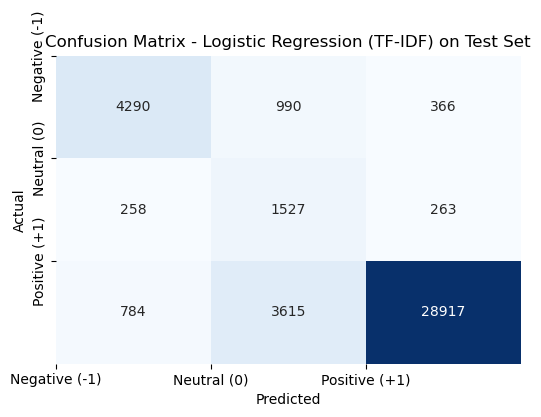

In [42]:
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression (TF-IDF) on Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=[0, 1, 2], labels=['Negative (-1)', 'Neutral (0)', 'Positive (+1)'])
plt.yticks(ticks=[0, 1, 2], labels=['Negative (-1)', 'Neutral (0)', 'Positive (+1)'])
plt.show()